In [20]:
!pip install -q torchinfo

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import torch
from torch import nn
from torchinfo import summary
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os

In [23]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/fruits1.zip','r')
zip_ref.extractall()
zip_ref.close()

In [24]:
#Step 1: Download and Extract Dataset

import requests
from pathlib import Path
import os
from zipfile import ZipFile

url = "/content/drive/MyDrive/fruits1.zip"


# Check if the file already exists
file_path = Path(url)
if file_path.is_file():
    print(f"{file_path} already exists.")
else:
    print("Please provide a valid path to your dataset file.")


# Define the path to the data directory
data_path = Path("data")
image_path = data_path / "fruits1"

# Check if the image directory already exists
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    # Extract the contents of the zip file to the image directory
    with ZipFile(file_path, "r") as zipref:
        zipref.extractall(image_path)

/content/drive/MyDrive/fruits1.zip already exists.
data/fruits1 directory exists.


In [25]:
# Step 2: Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [26]:
#Step 3: Create Dataset and DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
BATCH_SIZE = 32
# Change data_dir to the extracted dataset directory
data_dir = Path("/content/dataset")
training_dataset = ImageFolder(root='/content/dataset/Train', transform=train_transform)
test_dataset = ImageFolder(root='/content/dataset/Test', transform=test_transform)
training_dataloader = DataLoader(dataset=training_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=2)

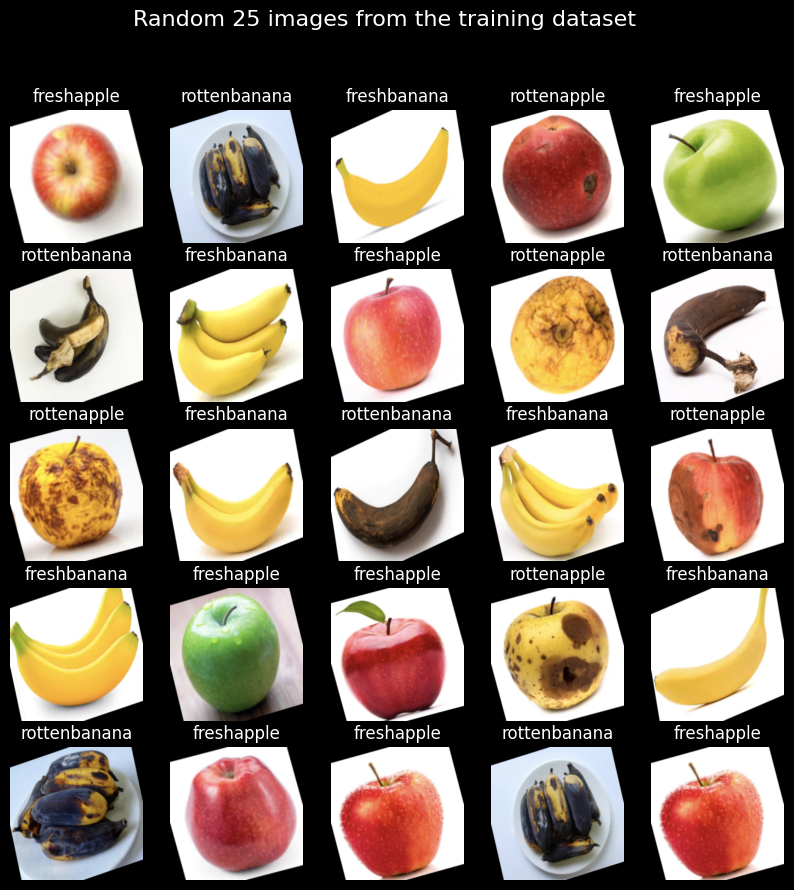

In [27]:
#Step 4: Visualize Random Samples

import matplotlib.pyplot as plt
import random
num_rows = 5
num_cols = num_rows
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i in range(num_rows):
  for j in range(num_cols):
    image_index = random.randrange(len(training_dataset))
    axs[i, j].imshow(training_dataset[image_index][0].permute((1, 2, 0)))
    axs[i, j].set_title(training_dataset.classes[training_dataset[image_index][1]], color="white")
    axs[i, j].axis(False)
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")
fig.set_facecolor(color='black')
plt.show()

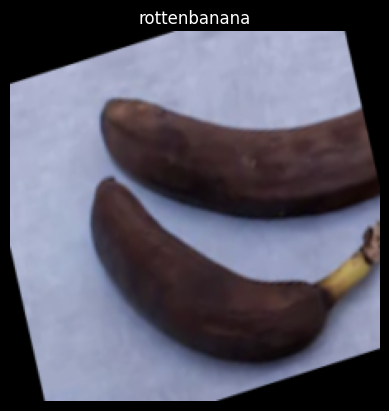

In [28]:
#Step 5: Patch Embedding

import torch
from torch import nn
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE == 0, "Image size not divisible by patch size"
conv_layer = nn.Conv2d(in_channels=IMAGE_CHANNELS, out_channels=EMBEDDING_DIMS, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
random_images,random_labels = next(iter(training_dataloader))
random_image = random_images[0]
fig = plt.figure(1)
plt.imshow(random_image.permute((1, 2, 0)))
plt.axis(False)
plt.title(training_dataset.classes[random_labels[0]], color="white")
fig.set_facecolor(color="black")
image_through_conv = conv_layer(random_image.unsqueeze(0))
image_through_conv = image_through_conv.permute((0, 2, 3, 1))
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
image_through_conv_and_flatten = flatten_layer(image_through_conv)
embedded_image = image_through_conv_and_flatten
class_token_embeddings = nn.Parameter(torch.rand((1, 1, EMBEDDING_DIMS), requires_grad=True))
embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim=1)
position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS), requires_grad=True))
final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings

In [29]:
class PatchEmbeddingLayer(nn.Module):
  def __init__(self, in_channels, patch_size, embedding_dim):
    super().__init__()
    self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
    self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
    # The class token embeddings should be initialized with a batch size of 1
    # and then expanded to the actual batch size during the forward pass
    self.class_token_embeddings = nn.Parameter(torch.rand((1, 1, embedding_dim), requires_grad=True))
    self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, embedding_dim), requires_grad=True))

  def forward(self, x):
    x = self.conv_layer(x).permute((0, 2, 3, 1))
    x = self.flatten_layer(x)
    # Expand the class token embeddings to match the batch size of the input
    batch_size = x.shape[0]
    expanded_class_token_embeddings = self.class_token_embeddings.expand(batch_size, -1, -1)
    x = torch.cat((expanded_class_token_embeddings, x), dim=1)
    x = x + self.position_embeddings
    return x

In [30]:
#Step 7: Multi-Head Self Attention Block

class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dims=768, num_heads=12, attn_dropout=0.0): # Changed init to __init__
    super().__init__()
    self.layernorm = nn.LayerNorm(normalized_shape=embedding_dims)
    self.multiheadattention = nn.MultiheadAttention(num_heads=num_heads, embed_dim=embedding_dims, dropout=attn_dropout, batch_first=True)

  def forward(self, x):
    x = self.layernorm(x)
    output, _ = self.multiheadattention(query=x, key=x, value=x, need_weights=False)
    return output

In [31]:
#Step 8: MLP Block

class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout): # Changed init to __init__
    super().__init__()
    self.layernorm = nn.LayerNorm(normalized_shape=embedding_dims)
    self.mlp = nn.Sequential( nn.Linear(in_features=embedding_dims, out_features=mlp_size), nn.GELU(), nn.Dropout(p=mlp_dropout), nn.Linear(in_features=mlp_size, out_features=embedding_dims), nn.Dropout(p=mlp_dropout) )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [32]:
#Step 9: Transformer Block

class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims=768, mlp_dropout=0.1, attn_dropout=0.0, mlp_size=3072, num_heads=12): # Changed init to __init__
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims, num_heads, attn_dropout)
    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims, mlp_size, mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [33]:
#Step 10: ViT Class

class ViT(nn.Module):
  def __init__(self, img_size=224, in_channels=3, patch_size=16, embedding_dims=768, num_transformer_layers=12, mlp_dropout=0.1, attn_dropout=0.0, mlp_size=3072, num_heads=12, num_classes=4): # Changed init to __init__
    super().__init__()
    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels, patch_size, embedding_dims)
    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims, mlp_dropout, attn_dropout, mlp_size, num_heads)
    for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential( nn.LayerNorm(normalized_shape=embedding_dims), nn.Linear(in_features=embedding_dims, out_features=num_classes) )

  # Indent the forward function to make it a method of the ViT class
  def forward(self, x):
    x = self.patch_embedding_layer(x)
    x = self.transformer_encoder(x)
    return self.classifier(x[:, 0])

vit = ViT(num_classes=4)

from torchinfo import summary
summary(model=vit, input_size=(BATCH_SIZE, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 4]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (conv_layer)                                   [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                               [32, 14, 14, 768]    [32, 196, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerBlock (0)                                  [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 197, 768]       [32, 197, 76

In [34]:
# Training loop
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, epochs=3, learning_rate=1e-3):
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss using the criterion
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [35]:
# Evaluate model

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate the model
# Replace 'model' with 'vit' to use your defined ViT model
train_model(vit, training_dataloader, epochs=10)
evaluate_model(vit, test_dataloader)

Epoch [1/10], Loss: 5.1530
Epoch [2/10], Loss: 2.3153
Epoch [3/10], Loss: 1.6606
Epoch [4/10], Loss: 1.6460
Epoch [5/10], Loss: 1.4547
Epoch [6/10], Loss: 1.4344
Epoch [7/10], Loss: 1.4459
Epoch [8/10], Loss: 1.4026
Epoch [9/10], Loss: 1.4314
Epoch [10/10], Loss: 1.4123
Test Accuracy: 25.00%


Enter image paths (comma-separated): /content/applefresh.jpg

Processing image 1: /content/applefresh.jpg
Prediction: The fruit is *freshapple*.


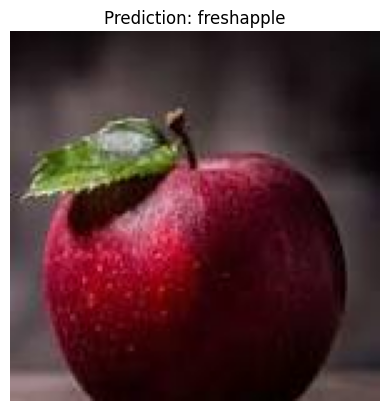

In [36]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Make sure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

# Define image transform (same as test)
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Prediction function
def predict_fruit(image_path, model=vit, transform=predict_transform, class_names=None):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return "Invalid image", None

    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_idx = torch.max(outputs, 1)

    if class_names is None:
        class_names = training_dataset.classes  # Should be ["fresh", "stale"]

    predicted_label = class_names[predicted_idx.item()]
    return predicted_label, image

# Main function
def main():
    image_paths = input("Enter image paths (comma-separated): ")
    if not image_paths:
        print("No image paths provided.")
        return

    image_paths = [path.strip() for path in image_paths.split(",")]

    for idx, image_path in enumerate(image_paths):
        if not os.path.exists(image_path):
            print(f"Image path {image_path} does not exist.")
            continue

        print(f"\nProcessing image {idx + 1}: {image_path}")
        prediction, img = predict_fruit(image_path)
        print(f"Prediction: The fruit is *{prediction}*.")

        if img:
            plt.imshow(img)
            plt.title(f"Prediction: {prediction}")
            plt.axis('off')
            plt.show()

if __name__ == "__main__":
    main()
